In [1]:
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nibabel.processing as nibpro
import SimpleITK as sitk
import json
import matplotlib.patches as mpatches
from pathlib import Path
from PIL import Image, ImageEnhance
from matplotlib import cm
import matplotlib
import re

### Prepare MMWHS: Orient main volume by Slicer3D view

In [5]:
def cut_slice(volume):
    return torch.from_numpy(volume.get_fdata())[:,:,volume.shape[-1]//2]

def switch_rows(affine_mat):
    affine_mat = affine_mat.clone()
    affine_mat[:3] = affine_mat.detach()[:3].flip(0)
    return affine_mat

def slicer_slice_transform(nii_volume, ras_affine_mat: np.ndarray, fov_mm, fov_vox, is_label=False):

    # (IJK -> RAS+).inverse() @ (Slice -> RAS+) == Slice -> IJK
    affine_mat =  torch.tensor(nii_volume.affine).inverse() @ ras_affine_mat

    # Get spacing and size related metrics
    nii_shape = torch.tensor(nii_volume.shape)

    origin = torch.tensor(nii_volume.affine[:3,-1])

    fov_scale = fov_mm / nii_shape

    # Prepare volume
    volume = torch.from_numpy(nii_volume.get_fdata())
    volume = volume.view([1,1]+nii_shape.tolist())

    # Rescale matrix for field of view
    fov_scale_mat = torch.eye(4)
    fov_scale_mat[:3,:3] = torch.diag(fov_scale)
    affine_mat = affine_mat @ fov_scale_mat.double()

    # Adjust offset
    affine_mat[:3,-1] = (affine_mat[:3,-1])*2.0/nii_shape - 1.0 # double origin? # double spacing?

    # Rescale matrix by D,H,W dimension
    # affine_mat[:3, :3] = torch.tensor([
    #     [mat[0,0]*D/D, mat[0,1]*H/D, mat[0,2]*W/D],
    #     [mat[1,0]*D/H, mat[1,1]*H/H, mat[1,2]*W/H],
    #     [mat[2,0]*D/W, mat[2,1]*H/W, mat[2,2]*W/W]
    # ])
    # Is equivalent to:
    rescale_mat = \
        nii_shape.view(1,3) * (1/nii_shape).view(3,1) # double spacing?
    
    affine_mat[:3, :3] = affine_mat[:3, :3] * rescale_mat

    # Switch D,W dimension of matrix (needs two times switching on rows and on columns)
    affine_mat = switch_rows(affine_mat)
    
    affine_mat = affine_mat.T
    affine_mat = switch_rows(affine_mat)
    affine_mat = affine_mat.T
    
    # Reflect on last dimension (only needed for slicer perfect view alignment, otherwise result is mirrored)
    reflect_mat = torch.tensor([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,-1,0],
        [0,0,0,1]
    ]).double()
    affine_mat = affine_mat @ reflect_mat

    # print("Modified affine")
    # print(affine_mat)
    # print()

    target_shape = torch.Size([1, 1] + fov_vox.tolist())

    grid = torch.nn.functional.affine_grid(affine_mat[:3,:].view(1,3,4), target_shape, align_corners=False)

    if is_label:
        resampled = torch.nn.functional.grid_sample(volume, grid, align_corners=False, mode='nearest')
    else:
        resampled = torch.nn.functional.grid_sample(volume, grid, align_corners=False)

    resampled = resampled.squeeze()

    resampled_affine = torch.eye(4)
    resampled_affine[:3,:3] = torch.diag(fov_mm/fov_vox) # TODO: This is not 100% correct - volume is not aligned correctly in space but at least undistorted

    nii_resampled = nib.Nifti1Image(resampled.cpu().numpy(), affine=resampled_affine)
    return nii_resampled
    
def crop_around_label_center(image_path, label_path, vox_size):

    label_center = !c3d {label_path} -centroid
    label_center_vox = label_center[0]

    str_elems = re.sub(r"[\[\]A-Za-z\,_]", "", label_center_vox).strip().split(' ')

    vox_center = np.array([float(elem) for elem in str_elems])
    vox_lower = np.floor(vox_center - vox_size/2).clip(min=0)
    v_origin = 'x'.join([str(int(elem)) for elem in vox_lower.tolist()])+'vox'
    v_size = 'x'.join([str(int(elem)) for elem in vox_size.tolist()])+'vox'

    !c3d {image_path} -region {v_origin} {v_size} -o {image_path}
    !c3d {label_path} -region {v_origin} {v_size} -o {label_path}


In [6]:
def plot_slices(red_slice, green_slice, yellow_slice, vmin=0.0, vmax=1.0):
    fig_img = plt.figure()
    new_plot = fig_img.add_subplot(131)
    plt.imshow(red_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(132)
    plt.imshow(green_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(133)
    plt.imshow(yellow_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)

    axs = fig_img.axes
    axs[0].set_title("red")
    axs[1].set_title("green")
    axs[2].set_title("yellow")
    plt.show()

In [7]:
mmwhs_base_path = "../../data/MMWHS"

mri_1002_nii = nib.load(Path(mmwhs_base_path, "mr_train/mr_train_1002_image.nii.gz"))
mri_1002_gt_nii = nib.load(Path(mmwhs_base_path, "mr_train/mr_train_1002_label.nii.gz"))

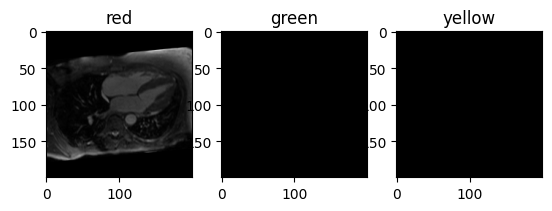

In [8]:
red_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_HLA_red_slice_to_ras.mat"))
red_volume = slicer_slice_transform(mri_1002_nii, red_slice_to_ras_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]))
red_label = slicer_slice_transform(mri_1002_gt_nii, red_slice_to_ras_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]), is_label=True)
red_slice = cut_slice(red_volume)
ref_img_path = Path(mmwhs_base_path, "preprocessed/train_HLA_4_chamber/mr_train_1002_image_HLA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)
nib.save(red_volume, ref_img_path)
nib.save(red_label, Path(mmwhs_base_path, "preprocessed/train_HLA_4_chamber/mr_train_1002_label_HLA.nii.gz"))
plot_slices(red_slice, torch.zeros_like(red_slice), torch.zeros_like(red_slice), vmax=red_volume.get_fdata().max().item())

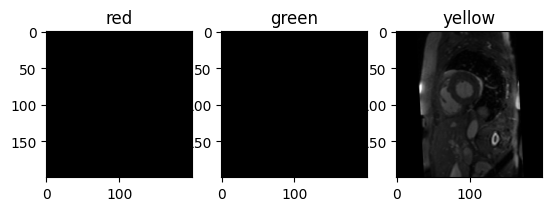

In [9]:
yellow_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_yellow_slice_to_ras.mat"))
yellow_volume = slicer_slice_transform(mri_1002_nii, yellow_slice_to_ras_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]))
yellow_label = slicer_slice_transform(mri_1002_gt_nii, yellow_slice_to_ras_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]), is_label=True)
ref_img_path = Path(mmwhs_base_path, "preprocessed/train_SA/mr_train_1002_image_SA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)
nib.save(yellow_volume, ref_img_path)
nib.save(yellow_label, Path(mmwhs_base_path, "preprocessed/train_SA/mr_train_1002_label_SA.nii.gz"))
yellow_slice = cut_slice(yellow_volume)

plot_slices(torch.zeros_like(yellow_slice), torch.zeros_like(yellow_slice), yellow_slice, vmax=red_volume.get_fdata().max().item())

### Prepare MMWHS: Reorient volumes based on 1002 fixed labels with c3d and store as modified volume

In [10]:
mmwhs_base_path = "../../data/MMWHS"

c3d = "/share/data_supergrover1/weihsbach/shared_data/tmp/c3d/c3d-1.1.0-Linux-gcc64/bin/c3d"

FIXED_ID = 1002
moving_ids = list(range(1001, 1021, 1))

DOF = 6
# USE_NNUNET_NAMES = False

for vieww in ["SA", "HLA"]:
    for mod in ["CT", "MR"]:
        # s_dir = "train_HLA_4_chamber" if vieww == "HLA" else "train_SA"
        s_dir = "train"
        print(f"Registering view '{vieww}' for modality '{mod}'")

        # fixed_label_filepath = Path(mmwhs_base_path, "preprocessed", s_dir, f"mr_train_{FIXED_ID}_label_{vieww}.nii.gz")
        # fixed_image_filepath = Path(mmwhs_base_path, "preprocessed", s_dir, f"mr_train_{FIXED_ID}_image_{vieww}.nii.gz")

        fixed_label_filepath = Path(mmwhs_base_path, "mr_train", f"mr_train_{FIXED_ID}_label.nii.gz")
        fixed_image_filepath = Path(mmwhs_base_path, "mr_train", f"mr_train_{FIXED_ID}_image.nii.gz")

        for m_id in moving_ids:
            print(f"Transforming {m_id} to {FIXED_ID}")
            # affine_path = Path(mmwhs_base_path, "preprocessed", s_dir, f"f{FIXED_ID}mr_m{m_id}{mod.lower()}_{vieww}.mat")
            affine_path = Path(mmwhs_base_path, "preprocessed", f"f{FIXED_ID}mr_m{m_id}{mod.lower()}.mat")
            affine_path.parent.mkdir(exist_ok=True, parents=True)
            print(affine_path)

            moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_image.nii.gz")
            moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_label.nii.gz")

            !{c3d} {fixed_label_filepath} {moving_label_filepath} -align-landmarks {DOF} {affine_path}

Registering view 'SA' for modality 'CT'
Transforming 1001 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1001ct.mat
Transforming 1002 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1002ct.mat
Transforming 1003 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1003ct.mat
Transforming 1004 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1004ct.mat
Transforming 1005 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1005ct.mat
Transforming 1006 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1006ct.mat
Transforming 1007 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1007ct.mat
Transforming 1008 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1008ct.mat
Transforming 1009 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1009ct.mat
Transforming 1010 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1010ct.mat
Transforming 1011 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1011ct.mat
Transforming 1012 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1012ct.mat
Transforming 1013 to 1002
../../data/MMWHS/prepr

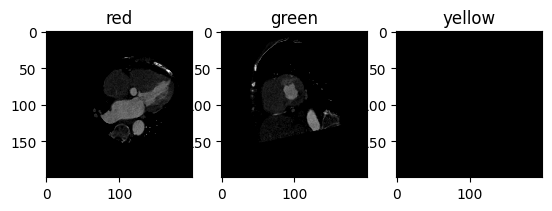

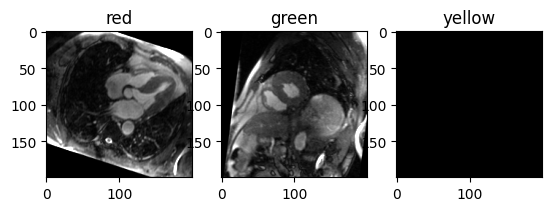

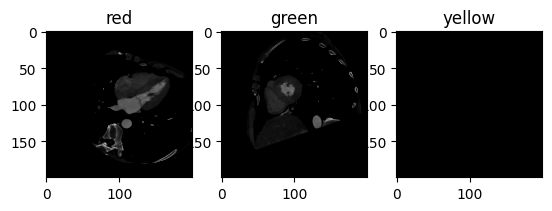

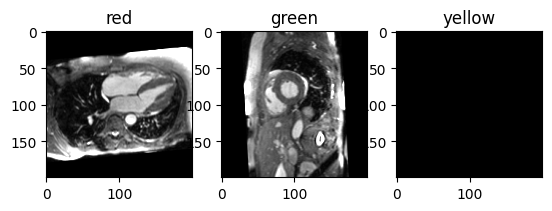

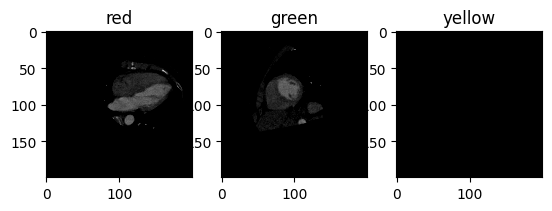

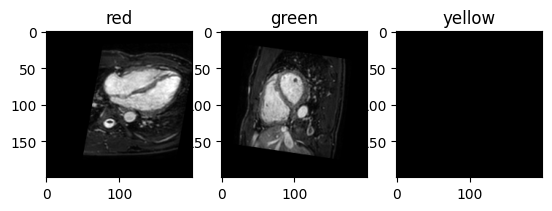

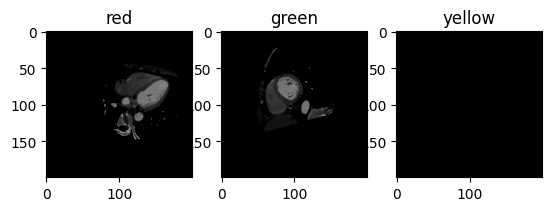

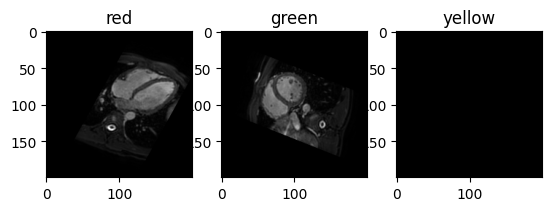

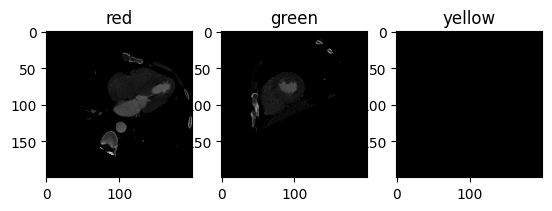

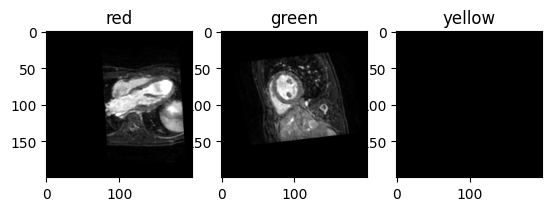

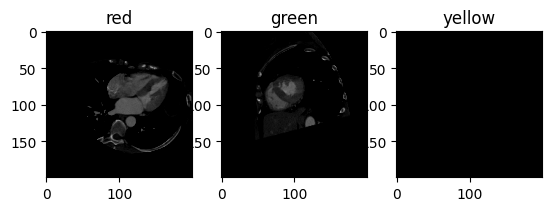

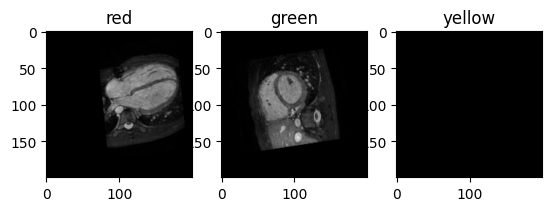

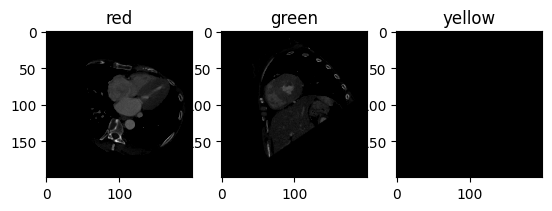

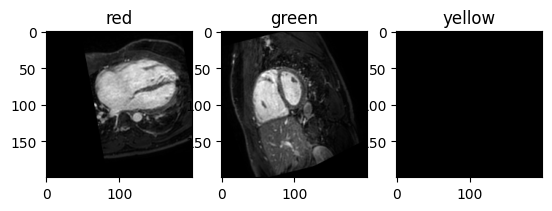

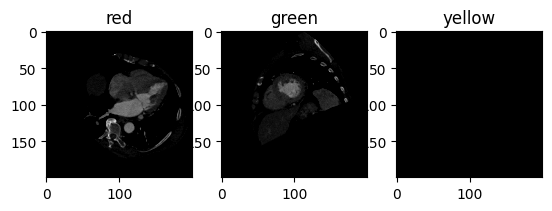

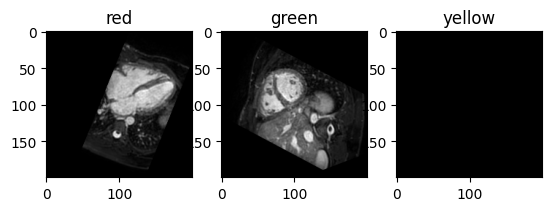

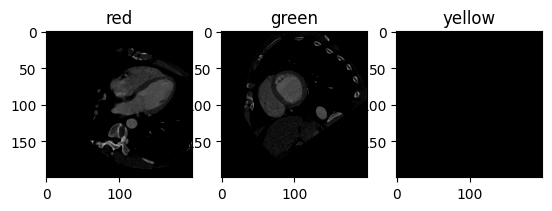

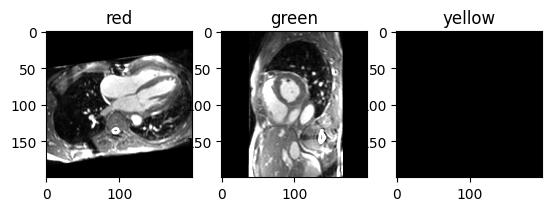

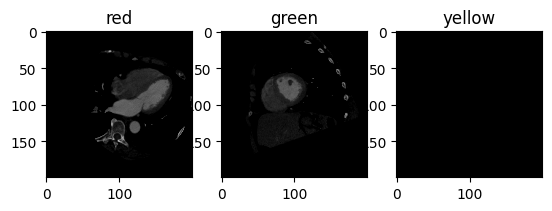

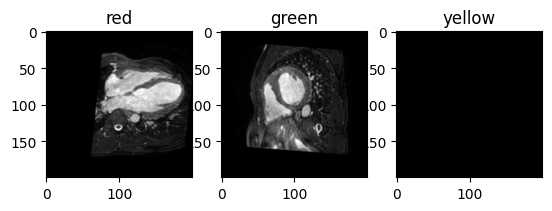

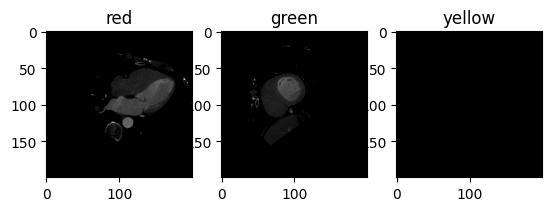

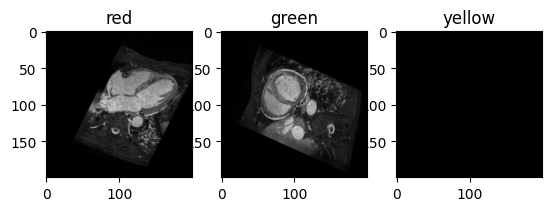

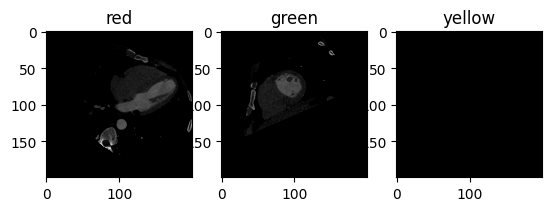

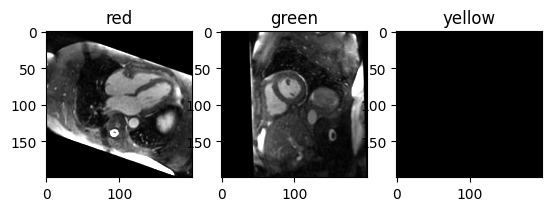

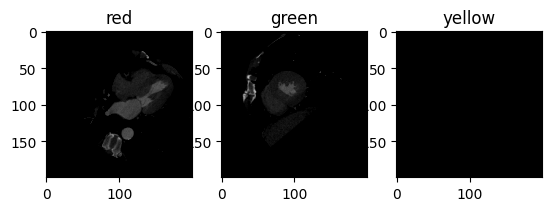

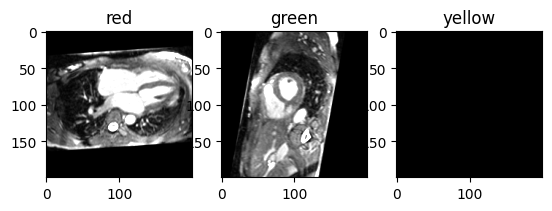

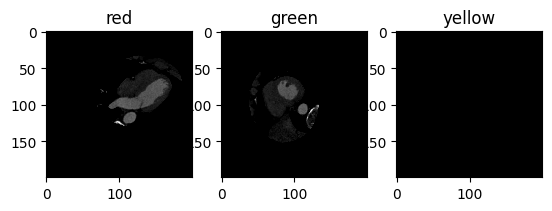

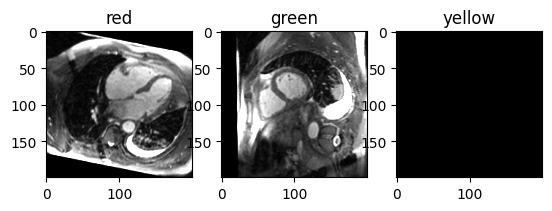

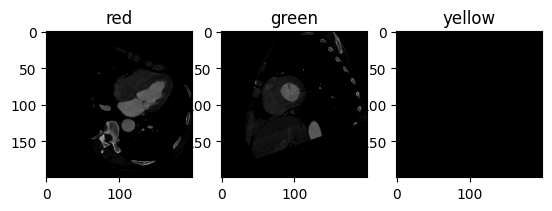

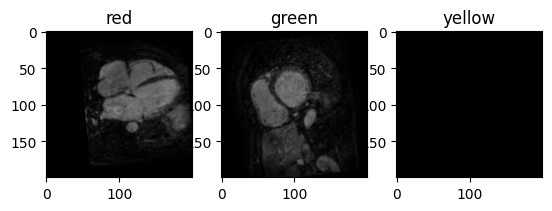

FileNotFoundError: /share/data_supergrover1/weihsbach/shared_data/tmp/slice_inflate/data/MMWHS/preprocessed/train/f1002mr_m1016ct.mat not found.

In [23]:
mmwhs_base_path = "../../data/MMWHS"

for p_id in range(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_nii = nib.load(Path(mmwhs_base_path, f"{mod_id}_train/{mod_id}_train_{p_id}_image.nii.gz"))
        mri_gt_nii = nib.load(Path(mmwhs_base_path, f"{mod_id}_train/{mod_id}_train_{p_id}_label.nii.gz"))

        align_mat = torch.from_numpy(np.loadtxt(f"/share/data_supergrover1/weihsbach/shared_data/tmp/slice_inflate/data/MMWHS/preprocessed/f1002mr_m{p_id}{mod_id}.mat"))
        hla_mat = align_mat @ red_slice_to_ras_mat
        sa_mat =  align_mat @ yellow_slice_to_ras_mat

        hla_volume = slicer_slice_transform(mri_nii, hla_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]))
        hla_label = slicer_slice_transform(mri_gt_nii, hla_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]), is_label=True)
        sa_volume = slicer_slice_transform(mri_nii, sa_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]))
        sa_label = slicer_slice_transform(mri_gt_nii, sa_mat, fov_mm=torch.tensor([300,300,300]), fov_vox=torch.tensor([200,200,200]), is_label=True)

        hla_slc = cut_slice(hla_volume)
        sa_slc = cut_slice(sa_volume)

        plot_slices(hla_slc, sa_slc, torch.zeros_like(sa_slc), vmax=volume.get_fdata().max().item())